In [487]:
import re
import pickle
import json
import contextlib
import joblib
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from typing import Callable, Any
from pathlib import Path
from os import cpu_count
from joblib import load, Parallel, delayed, wrap_non_picklable_objects
from shutil import rmtree
from scipy.stats import binom, norm, chi2, gamma, t, mode, ecdf, gaussian_kde
from scipy.special import betainc
from tqdm import tqdm
from pandas.api.types import is_datetime64_any_dtype
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_absolute_error, mean_squared_error

import var_backtest
import es_backtest
importlib.reload(var_backtest)
importlib.reload(es_backtest)
from var_backtest import run_tests as run_VaR_backtests
from es_backtest import run_tests_llm as run_ES_backtests_llm

In [71]:
def convert_excel_to_csv_files(directory: Path):
    for excel_file in directory.glob("*.xlsx"):
        output_file = excel_file.with_suffix(".csv")
        if not output_file.exists():
            excel_contents = pd.read_excel(excel_file)
            if "Date" in excel_contents.columns and not is_datetime64_any_dtype(excel_contents["Date"]):
                raise ValueError(f"File '{excel_file.as_posix()}': Column 'Date' is not of datetime type. Check the file.")
            excel_contents.to_csv(output_file, index=False)

def convert_predictions_to_csv(root_directory: Path):
    print(f"Converting files in '{root_directory.as_posix()}'...")
    convert_excel_to_csv_files(root_directory)
    for child_directory in root_directory.glob("*"):
        if child_directory.is_dir():
            print(f"Converting files in '{child_directory.as_posix()}'...")
            convert_excel_to_csv_files(child_directory)

In [73]:
convert_predictions_to_csv(Path("crix_temperature_simulations/"))

Converting files in 'crix_temperature_simulations'...
Converting files in 'crix_temperature_simulations/gpt_4o'...
Converting files in 'crix_temperature_simulations/gpt_4'...
Converting files in 'crix_temperature_simulations/.ipynb_checkpoints'...
Converting files in 'crix_temperature_simulations/gpt_3.5'...


# Parameters

The whole notebook will run only on assets included in LLM simulations.
Therefore, it is important for all other methods to include at least these assets.

In [332]:
# Settings to find LLM prediction files
# simulations_directory =  LLM simulations directory (wrapped in Path())
# asset_regex = a regex of file names with a group for the asset name
# temperature_regex = a regex for the file names with a group on the temperature
# glob_pattern = a glob pattern for identifying files; cannot use a regex here, just a limited set of wildcards. Include {asset_name} where it fits.
# results_directory = results directory (wrapped in Path())
# Use 'prediction_type' to choose one particular setting - you shouldn't change here unless predicting on different assets/with different model
llm_simulation_settings = {
    "gpt-3.5-llmtime": {
        "simulations_directory": Path("crix_temperature_simulations/gpt_3.5"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime_gpt_3\.5.*",
        "temperature_regex": r".*_LLMTime_gpt_3\.5_turbo_instruct_w\d+_temp([\d\.]+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("crix_temperature_simulations/results"),
    },
    "gpt-4-llmtime": {
        "simulations_directory": Path("crix_temperature_simulations/gpt_4"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime_gpt_4.*",
        "temperature_regex": r".*_LLMTime_gpt_4_turbo_w\d+_temp([\d\.]+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("crix_temperature_simulations/results"),
    },
    "gpt-4o-llmtime": {
        "simulations_directory": Path("crix_temperature_simulations/gpt_4o"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime_gpt_4o.*",
        "temperature_regex": r".*_LLMTime_gpt_4o_w\d+_temp([\d\.]+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("crix_temperature_simulations/results"),
    },
}

In [150]:
# Which model do you want to test? Must define above
# prediction_type = "gpt-4o-llmtime"
# Original log return data
data_directory = Path("datasets")

# Significance level for VaR, ES, tests
# Must be precomputed for all methods orther than LLM
alpha_VaR = 0.01
alpha_ES = 0.025
# Student df parameter used for ES testing. Expected to be the same for all estimators
t_nu = 5
# All assets and estimations will start from this date onward
asset_starting_date = pd.Timestamp("2021-10-01 00:00:00")
# Used for consistency in ordering assets at test results
asset_table_ordering = ['CACT', 'DJCI', 'FTSE', 'CRIX', 'CBU', 'SP500', 'STOXX', 'SPGTCLTR', 'GDAXI']

In [156]:
def read_llmtime_assets(llm_simulation_settings: dict[str, str]):
    llmtime_assets = set()
    asset_regex = re.compile(llm_simulation_settings["asset_regex"])
    simulations_directory = llm_simulation_settings["simulations_directory"]
    for simulations_file in [file for file in simulations_directory.glob("*") if asset_regex.match(file.stem)]:
        llmtime_assets.add(asset_regex.match(simulations_file.stem).group(1))
    
    return list(llmtime_assets)
    
def read_llmtime_simulations(asset: str, llm_simulation_settings: dict[str, str]):
    normalized_asset_name = "".join([f"[{char.lower()}{char.upper()}]" for char in asset])
    temperature_regex = re.compile(llm_simulation_settings["temperature_regex"])
    simulations_directory = llm_simulation_settings["simulations_directory"]
    simulation_file_pattern = llm_simulation_settings["glob_pattern"].format(asset_name=normalized_asset_name)
    llmtime_temperature_predictions = {}
    
    for simulation_temperature_file in simulations_directory.glob(simulation_file_pattern):
        temperature = float(temperature_regex.match(simulation_temperature_file.stem).group(1))
        if simulation_temperature_file.suffix == ".csv":
            llmtime_temperature_predictions[temperature] = (
                pd.read_csv(simulation_temperature_file, parse_dates=["Date"]).set_index("Date")
                .drop(columns=["Model", "Temperature"])
            )
        elif simulation_temperature_file.suffix == ".xlsx":
            llmtime_temperature_predictions[temperature] = (
                pd.read_excel(simulation_temperature_file).set_index("Date")
                .drop(columns=["Model", "Temperature"])
            )
            llmtime_temperature_predictions[temperature].reset_index().to_csv(simulation_temperature_file.with_suffix(".csv"), index=False)
        else:
            raise ValueError("Only csv and Excel simulation files are supported at the moment; you can add more here.")

    return llmtime_temperature_predictions

def handle_unique_llm_predictions(llmtime_temperature_predictions: dict[str, dict[int, pd.DataFrame]]):
    llmtime_unique_predictions = {asset: {} for asset in llmtime_assets}
    rng = np.random.default_rng()
    for asset in llmtime_temperature_predictions.keys():
        for temperature in llmtime_temperature_predictions[asset].keys():
            test_llmtime_data = llmtime_temperature_predictions[asset][temperature]
            unique_predictions = test_llmtime_data[test_llmtime_data.nunique(axis=1) == 1]
            if len(unique_predictions) > 0:
                print(f"Asset {asset}, window {window_size}. Found {len(unique_predictions)} LLM predictions with only 1 unique value. Using the last available prediction instead.")
                for unique_prediction_date in unique_predictions.index:
                    unique_prediction_index = test_llmtime_data.reset_index()[test_llmtime_data.reset_index()["Date"] == unique_prediction_date].index[0]
                    # This might be the first index, in which case we search forwards
                    if unique_prediction_index == 0:
                        previous_valid_index = 1
                        while previous_valid_index < len(test_llmtime_data) and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index += 1
                        # If somehow we still haven't found a valid index, then the entire dataset is unique and we raise an error
                        if previous_valid_index == len(test_llmtime_data):
                            raise ValueError(f"There is no non-unique prediction for asset {asset}, window {window_size}.")
                    else:
                        # The previous index might also be unique, so search until we find the first non-unique
                        previous_valid_index = unique_prediction_index - 1
                        while previous_valid_index > 0 and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index -= 1
                        # If we arrive at the first index and found nothing, look forwards
                        if previous_valid_index < 0:
                            previous_valid_index = unique_prediction_index + 1
                        while previous_valid_index < len(test_llmtime_data) and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index += 1
                        # If somehow we still haven't found a valid index, then the entire dataset is unique and we raise an error
                        if previous_valid_index == len(test_llmtime_data):
                            raise ValueError(f"There is no non-unique prediction for asset {asset}, window {window_size}.")
                    # We keep the predicted value by randomnly removing one from the valid day
                    unique_value = test_llmtime_data.iloc[unique_prediction_index, 0]
                    test_llmtime_data.iloc[unique_prediction_index, :] = test_llmtime_data.iloc[previous_valid_index, :]
                    index_to_remove = rng.integers(0, test_llmtime_data.shape[1] - 1, size=1)
                    test_llmtime_data.iloc[unique_prediction_index, index_to_remove] = [unique_value]
                            

def read_original_asset_returns(asset: str):
    normalized_asset_name = "".join([f"[{char.lower()}{char.upper()}]" for char in asset])
    original_prices_file = list(data_directory.glob(f"{normalized_asset_name}.xlsx"))[0]
    original_prices = pd.read_excel(original_prices_file).set_index("Date")
    price_column = "Close" if asset != "stoxx" else "STOXX"
    log_returns = np.log(original_prices[price_column].pct_change() + 1)
    log_returns.fillna(log_returns.iloc[1], inplace=True)
    return log_returns

# Read datasets

In [157]:
llmtime_llms = {}
for prediction_type, settings in tqdm(llm_simulation_settings.items(), desc="Reading LLM simulations..."):
    # print(prediction_type)
    local_llmtime_assets = read_llmtime_assets(settings)
    if len(local_llmtime_assets) > 1:
        raise ValueError("Multiple assets not supported at the moment.")
    llm_label = prediction_type.replace("-llmtime", "")
    llmtime_predictions_for_type = {asset: read_llmtime_simulations(asset, settings) for asset in local_llmtime_assets}
    handle_unique_llm_predictions(llmtime_predictions_for_type)
    llmtime_llms[llm_label] = llmtime_predictions_for_type[local_llmtime_assets[0]]
    if set(llmtime_assets) != set(local_llmtime_assets):
        raise ValueError("LLMs predict different assets. Cannot continue unless this is fixed. Check settings above.")
    llmtime_assets = local_llmtime_assets
log_returns_dict = {asset: read_original_asset_returns(asset) for asset in llmtime_assets}
asset_table_ordering = [asset_label for asset_label in asset_table_ordering if asset_label in map(str.upper, llmtime_assets)]

Reading LLM simulations...: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


In [244]:
# Constant across all runs
window_size = next(iter(llmtime_llms[next(iter(llmtime_llms.keys()))].values()))["Window"].iloc[0]

In [231]:
def aggregate_model_predictions(results_dict: dict[str, dict[str, any]]):
    filtered_results_VaR, filtered_results_ES, filtered_results_volatility = {}, {}, {}

    for llm_label, predictions_dict in results_dict.items():
        llm_results_VaR, llm_results_ES, llm_results_volatility = [], [], []
        for temperature, predictions in predictions_dict.items():
            asset = predictions["Asset"].iloc[0]
            expected = log_returns_dict[asset]
            aligned_expected, aligned_preds = expected.align(predictions, join="inner", axis=0)
            if "volatility" in aligned_preds.columns:
                # GARCH fails for some days and we have volatility 0; here we use the previous day volatility
                aligned_preds.loc[aligned_preds["volatility"] == 0, "volatility"] = pd.NA
                aligned_preds["volatility"] =  aligned_preds["volatility"].ffill()
            llm_results_VaR.append(aligned_preds["VaR"].bfill().rename(temperature))
            llm_results_ES.append(aligned_preds["ES"].bfill().rename(temperature))
            if "volatility" in predictions.columns:
                llm_results_volatility.append(aligned_preds["volatility"].rename(temperature))
        
        llm_results_VaR_dict = {
            estimator_results.name: {asset: estimator_results.loc[asset_starting_date:].ffill()}
            for estimator_results in llm_results_VaR
        }
        llm_results_ES_dict = {
            estimator_results.name: {asset: estimator_results.loc[asset_starting_date:].ffill()}
            for estimator_results in llm_results_ES
        }
        llm_results_volatility_dict = {
            estimator_results.name: {asset: estimator_results.loc[asset_starting_date:].ffill()}
            for estimator_results in llm_results_volatility
        }
        # missing_assets = set(llmtime_assets) - set(list(list(llm_results_VaR_dict.keys())[0].keys())[0])
        # if len(missing_assets) == 0:
        filtered_results_VaR[llm_label] = llm_results_VaR_dict
        filtered_results_ES[llm_label] = llm_results_ES_dict
        filtered_results_volatility[llm_label] = llm_results_volatility_dict
        # else:
        #     print(f"LLM {llm_label}: Removing {temperature} for assets {list(missing_assets)}.")
        
    return filtered_results_VaR, filtered_results_ES, filtered_results_volatility
        

def estimate_llm_VaR_ES(llmtime_temperature_predictions: dict[int, pd.Series]):
    # We should compute ES with alpha 0.025, however at this moment we used 0.01 for all other methods
    return {
        temperature: pd.concat([
            temperature_data[[col for col in temperature_data.columns if "Log Return" in col]]
            .quantile(alpha_VaR, axis=1).rename("VaR"),
            temperature_data[[col for col in temperature_data.columns if "Log Return" in col]]
            .apply(lambda row: row.sort_values().iloc[:int(alpha_ES * len(row))].mean(), axis=1).rename("ES")
        ], axis=1).merge(
            temperature_data["Asset"], how="left", left_index=True, right_index=True
        )
        for temperature, temperature_data in llmtime_temperature_predictions.items()
    }

In [215]:
VaR_ES_llmtime_temperature_predictions = {
    llm_label: estimate_llm_VaR_ES(llmtime_temperature_predictions)
    for llm_label, llmtime_temperature_predictions in llmtime_llms.items()
}
# Gather all VaRs, ESs, and daily estimated volatilities in one dict of the form {estimator: {window: DataFrame with assets}}


In [232]:
VaR_predictions, ES_predictions, volatility_predictions = aggregate_model_predictions(VaR_ES_llmtime_temperature_predictions)

In [245]:
negative_ES = {
    llm_label + "_" + str(temperature) + "_" + asset: preds[preds >= 0].count() 
    for llm_label, temperatures_dict in ES_predictions.items() 
    for temperature, asset_dict in temperatures_dict.items()
    for asset, preds in asset_dict.items()
    if (preds >= 0).sum() > 0
}
negative_VaR = {
    llm_label + "_" + str(temperature) + "_" + asset: preds[preds >= 0].count() 
    for llm_label, temperatures_dict in VaR_predictions.items() 
    for temperature, asset_dict in temperatures_dict.items()
    for asset, preds in asset_dict.items()
    if (preds >= 0).sum() > 0
}

if len(negative_VaR) > 0 or len(negative_ES) > 0:
    negative_VaR_series, negative_ES_series = pd.Series(negative_VaR), pd.Series(negative_ES)
    negative_VaR_asset = negative_VaR_series.index.map(lambda text: text.split("_")[-1])
    negative_VaR_sizes = pd.Series([
        log_returns_dict[asset].iloc[window_size:].shape[0] 
        for asset in negative_VaR_asset
    ], index=negative_VaR_series.index)
    negative_VaR_percentages = negative_VaR_series / negative_VaR_sizes
    negative_VaR_to_signal = negative_VaR_percentages[negative_VaR_percentages > 0.8]
    if negative_VaR_to_signal.shape[0] > 0:
        raise ValueError(
            f"There are {len(negative_VaR_to_signal)} estimators with more than 80% positive VaR: {negative_VaR_to_signal.index.to_list()}. "
            "Maybe a sign has not been switched (we expect negative VaR and ES)."
        )

    negative_ES_asset = negative_ES_series.index.map(lambda text: text.split("_")[-1])
    negative_ES_sizes = pd.Series([
        log_returns_dict[asset].iloc[window_size:].shape[0] 
        for asset in negative_ES_asset
    ], index=negative_ES_series.index)
    negative_ES_percentages = negative_ES_series / negative_ES_sizes
    negative_ES_to_signal = negative_ES_percentages[negative_ES_percentages > 0.8]
    if negative_ES_to_signal.shape[0] > 0:
        raise ValueError(
            f"There are {len(negative_ES_to_signal)} estimators with more than 80% positive ES: {negative_ES_to_signal.index.to_list()}. "
            "Maybe a sign has not been switched (we expect negative VaR and ES)."
        )

In [221]:
def write_backtest_result(backtest_data: dict[str, pd.DataFrame], format_func: Callable[[float], str], output_name: str):
    # Assuming backtest_failure_rates is already defined and populated
    backtest_df = pd.DataFrame.from_dict(backtest_data, orient="index")
    
    # Multiply by 100 to convert to percentages
    backtest_df = backtest_df * 100
    
    # Round the DataFrame to 3 decimal places
    backtest_df = backtest_df.round(3)
    
    # Convert columns to uppercase and replace "NORMAL" with "N"
    backtest_df.columns = backtest_df.columns.str.upper().str.replace("NORMAL", "N")
    
    # Reorder columns for consistency
    backtest_df = backtest_df[asset_table_ordering]
    
    # Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
    backtest_df.index = (backtest_df.index.str.upper()
                              .str.replace("NORMAL", "N")
                              .str.replace("LLMTIME", "LLM")
                              .str.replace('_', '.'))
    
    # Create LaTeX table manually
    latex_code = "\\begin{tabular}{l" + "r" * len(backtest_df.columns) + "}\n"
    latex_code += " \\toprule\n"
    latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in backtest_df.columns]) + " \\\\\n"
    latex_code += " \\midrule\n"
    
    # Generate LaTeX table content, iterating through the DataFrame with 3 decimal formatting and color coding
    for idx, row in backtest_df.iterrows():
        latex_code += f"{idx} & " + " & ".join([format_func(val) for val in row]) + " \\\\\n"
    latex_code += " \\bottomrule\n"
    latex_code += "\\end{tabular}"
    
    # Write the LaTeX code to a .tex file
    with open(results_directory / f"{output_name}.tex", "w") as f:
        f.write(latex_code)
    
    # Export raw data (without styling) to CSV
    backtest_df.to_csv(results_directory / f"{output_name}.csv")

In [222]:
# Define a function to format numbers to 3 decimals and apply green-red palette
def format_p_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val <= 1:
            if val < 0.5:
                color = "green!30!white"  # Ligther green
            else:
                color = "green!70!white"  # Darker green 
        else:
            if val < 0.01:
                color = "red!30!white"  # Lighter
            else:
                color = "red!70!white"  # Darker
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

def format_traffic_light(value):
    if value < 0.95:
        return '\\cellcolor{green} ' + f'{value:.3f}'
    if 0.95 <= value < 0.99:
        return '\\cellcolor{yellow} ' + f'{value:.3f}'
    if value >= 0.99:
        return '\\cellcolor{red} ' + f'{value:.3f}'

In [307]:
def plot_exceedances(actual: pd.Series, forecast_VaR: pd.Series, ax=None, file_name=None):
    # sns.set_context("paper")
    # sns.set_style("white", {"font.family": "serif", "font.serif": "Computer Modern Roman", "text.usetex": True})

    # Hits
    if ax is None:
        plt.figure(figsize=(20, 10))
        ax = plt.gca()

    if (actual <= forecast_VaR).any():
        actual[actual <= forecast_VaR].plot(color="red", marker="o", ls="None", ax=ax)

    for exceendance_point in actual[actual <= forecast_VaR].index:
        ax.axvline(exceendance_point, color="black", alpha=0.4, linewidth=1, zorder=0)

    # Positive returns
    actual[forecast_VaR > actual].plot(ax=ax, color="green", marker="o", ls="None")

    # Negative returns but no hit
    actual[(forecast_VaR <= actual) & (forecast_VaR <= 0)].plot(ax=ax, color="orange", marker="o", ls="None")

    # VaR
    forecast_VaR.plot(ax=ax, grid=False, color="black", rot=0)

    # Axes
    ax.set_xlabel("")
    ax.set_ylabel("Log Returns")
    ax.yaxis.grid()

    if file_name is not None:
        plt.savefig(file_name, bbox_inches="tight", transparent=True)

# Forecasting performance

In [ ]:
llmtime_performance_mae = {asset: {} for asset in llmtime_assets}
llmtime_performance_mse = {asset: {} for asset in llmtime_assets}

for asset, window_data in llmtime_window_predictions.items():
    for window_size, llmtime_window_data in window_data.items():
        # print(window_size)
        # print(log_returns_dict[asset].iloc[window_size:].tail())
        # print(llmtime_window_data.mean(axis=1).tail())
        llmtime_merged_performance_data = log_returns_dict[asset].iloc[window_size:].to_frame(name="returns").merge(
            llmtime_window_data.mean(axis=1).rename("preds"), how="inner", left_index=True, right_index=True
        )
        llmtime_performance_mae[asset][window_size] = mean_absolute_error(llmtime_merged_performance_data["returns"], llmtime_merged_performance_data["preds"])
        llmtime_performance_mse[asset][window_size] = np.sqrt(mean_squared_error(llmtime_merged_performance_data["returns"], llmtime_merged_performance_data["preds"]))

# VaR Backtesting

In [247]:
VaR_backest_temperature_results = {}
for llm_label in VaR_predictions.keys():
    VaR_backest_temperature_results[llm_label] = run_VaR_backtests(VaR_predictions[llm_label], asset_returns=log_returns_dict, alpha=alpha_VaR)

In [544]:
failure_rates_temperature_data = pd.DataFrame({
    llm_label: {temperature: failure_rates_series.iloc[0] for temperature, failure_rates_series in llm_backtest_results["failure_rates"].items()}
    for llm_label, llm_backtest_results in VaR_backest_temperature_results.items()
}).sort_index()
failure_rates_temperature_data.index = failure_rates_temperature_data.index.astype(str)

In [534]:
VaR_backtesting_temperature_results = pd.DataFrame({
   llm_label:
       pd.Series({temperature: int(kupiec_pvalue.iloc[0] > 0.05) for temperature, kupiec_pvalue in VaR_backest_results["kupiec"].items()}).add(
            pd.Series(
                {temperature: int(traffic_light.iloc[0] < 0.95) for temperature, traffic_light in VaR_backest_results["traffic_light_normal"].items()
            })
       ).add(
            pd.Series({
                temperature: int(christoffersen.iloc[0] > 0.05) # np.logical_or(christoffersen.iloc[0] == "NF", 
                for temperature, christoffersen in VaR_backest_results["christoffersen"].items()
            })
       )
    for llm_label, VaR_backest_results in VaR_backest_temperature_results.items()
})
VaR_backtesting_temperature_results.index = VaR_backtesting_temperature_results.index.astype(str)

In [333]:
# Loop over all assets and all models in VaR_backtest_dict
for llm_label, llm_predictions_data in tqdm(VaR_predictions.items(), desc="Generating LLM exceedance plots..."):
    results_directory = llm_simulation_settings[llm_label + "-llmtime"]["results_directory"]
    plot_results_directory = results_directory / "exceedance_plots"
    plot_results_directory.mkdir(parents=True, exist_ok=True)

    # Extract the backtest data for each temperature
    exceedance_plot_size = (4, 3)
    fig = plt.figure(figsize=(30, 18))
    for i, (temperature, llm_VaR_predictions) in enumerate(sorted(llm_predictions_data.items(), key=lambda item: item[0])):
        llm_asset = next(iter(llm_VaR_predictions.keys()))
        llm_VaR_asset_predictions = llm_VaR_predictions[llm_asset]
        # print(temperature)
        # Plot the data for the current model
        if temperature < 0.7:
            exceedance_plot_row_index, exceedance_plot_col_index = (i // exceedance_plot_size[1], i % exceedance_plot_size[1])
            current_ax = plt.subplot2grid(exceedance_plot_size, (exceedance_plot_row_index, exceedance_plot_col_index), fig=fig)
        elif temperature == 0.7:
            current_ax = plt.subplot2grid(exceedance_plot_size, (exceedance_plot_size[0] - 1, 1), colspan=exceedance_plot_size[1] - 1, fig=fig)
        else:
            exceedance_plot_row_index, exceedance_plot_col_index = ((i - 1) // exceedance_plot_size[1], (i - 1) % exceedance_plot_size[1])
            current_ax = plt.subplot2grid(exceedance_plot_size, (exceedance_plot_row_index, exceedance_plot_col_index), fig=fig)
        exceendance_returns, exceedance_VaR = log_returns_dict[llm_asset].loc[asset_starting_date:].iloc[window_size:].align(
            llm_VaR_asset_predictions, join="inner", axis=0
        )
        plot_exceedances(actual=exceendance_returns, forecast_VaR=exceedance_VaR, ax=current_ax)
        
        # Set the title with the formatted model name and asset
        #ax.set_title(f"{plot_asset_exceedances.upper()} - {formatted_model_name}")
        
        # Format the x-axis to display dates properly without overlapping
        current_ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))  # Major ticks every 90 days
        current_ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))   # Minor ticks every 7 days
        current_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as year-month-day
        
        # Rotate date labels for clarity
        plt.setp(current_ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
        # Set x axis title with latex font
        current_ax.set_xlabel(fr"$T = {temperature}$", fontsize=30)
    
        # Set no y axis label
        current_ax.set_ylabel("")
        
    # Set tight layout to prevent clipping of tick-labels and titles
    plt.tight_layout()

    # Space subplots height otherwise clipping would occur
    plt.subplots_adjust(hspace=0.45)

    # Save each plot as a separate file
    plt.savefig(plot_results_directory / f"VaR_exceedances_{llm_label}.png", transparent=True, bbox_inches="tight")
    
    # Close the figure to avoid display during loop
    plt.close(fig)


Generating LLM exceedance plots...: 100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


# ES Backtesting

### Plotting distributions

We use Kernel Density Estimation to plot the distribution of log returns and the LLM estimation.

For each day, we choose the modal value as a representative because of many repeating values.

In [337]:
for llm_label, llm_predictions_data in tqdm(VaR_predictions.items(), desc="Generating LLM distribution plots..."):
    results_directory = llm_simulation_settings[llm_label + "-llmtime"]["results_directory"]
    distribution_plot_results_directory = results_directory / "distribution_plots"
    # if distribution_plot_results_directory.exists():
    #     rmtree(distribution_plot_results_directory)
    distribution_plot_results_directory.mkdir(parents=True, exist_ok=True)

    distribution_plot_size = (4, 3)
    fig = plt.figure(figsize=(30, 18))
    for i, (temperature, llm_VaR_predictions) in enumerate(sorted(llm_predictions_data.items(), key=lambda item: item[0])):
        llm_asset = next(iter(llm_VaR_predictions.keys()))
        llm_VaR_asset_predictions = llm_VaR_predictions[llm_asset]
        if temperature < 0.7:
            distribution_plot_row_index, distribution_plot_col_index = (i // distribution_plot_size[1], i % distribution_plot_size[1])
            current_ax = plt.subplot2grid(exceedance_plot_size, (distribution_plot_row_index, distribution_plot_col_index), fig=fig)
        elif temperature == 0.7:
            current_ax = plt.subplot2grid(distribution_plot_size, (distribution_plot_size[0] - 1, 1), colspan=distribution_plot_size[1] - 1, fig=fig)
        else:
            distribution_plot_row_index, distribution_plot_col_index = ((i - 1) // distribution_plot_size[1], (i - 1) % distribution_plot_size[1])
            current_ax = plt.subplot2grid(distribution_plot_size, (distribution_plot_row_index, distribution_plot_col_index), fig=fig)
        distribution_plot_returns, distribution_plot_VaR = log_returns_dict[llm_asset].loc[asset_starting_date:].iloc[window_size:].align(
            llm_VaR_asset_predictions, join="inner", axis=0
        )
        sns.kdeplot(distribution_plot_returns, ax=current_ax, fill=True, linewidth=2, color=plt.get_cmap("tab10")(0), label="Actual")
        sns.kdeplot(distribution_plot_VaR, ax=current_ax, fill=True, linewidth=2, color=plt.get_cmap("tab10")(3), label="LLM")

        current_ax.set_xlabel(fr"$T = {temperature}$", fontsize=30)
        current_ax.set_ylabel("")
        # current_ax.legend(loc="upper right")
    
    # plt.suptitle(f"Distribution plot for LLMTime window {llmtime_test_window}", fontsize=40)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.45)

    plt.savefig(distribution_plot_results_directory / f"distribution_plot_{llm_label}.png", transparent=True, bbox_inches="tight")
    plt.close(fig)

Generating LLM distribution plots...: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


In [ ]:
ES_backtesting_results_dict = run_ES_backtests_llm(
    ES_predictions=ES_predictions,
    VaR_predictions=VaR_predictions,
    volatilities=volatility_predictions,
    llmtime_llms=llmtime_llms,
    asset_returns=log_returns_dict,
    alpha=alpha_ES,
)

Z2 ES LLM...: 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]
Z2 ES other methods...: 0it [00:00, ?it/s]
Z3 ES LLM...: 100%|██████████| 11/11 [12:14<00:00, 66.76s/it]  
Z3 ES other methods...: 0it [00:00, ?it/s]
Z2 ES LLM...: 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]
Z2 ES other methods...: 0it [00:00, ?it/s]
Z3 ES LLM...:   0%|          | 0/11 [00:00<?, ?it/s]

In [507]:
ES_backtesting_results_dict_inverted = {
    llm_label: {
        "Z2": ES_backtesting_results_dict["Z2"][llm_label],
        "Z3": ES_backtesting_results_dict["Z3"][llm_label],
    }
    for llm_label in ES_predictions.keys()
}

In [533]:
ES_backesting_results_frame = pd.DataFrame({
    llm_label: 
       pd.Series({
           re.sub(r"\_\w+", "", temperature): int(Z2_value > 0.05) for temperature, Z2_value in ES_backtesting_results["Z2"]["p-value"].iloc[:, 0].items()
       }).add(
            pd.Series({
                re.sub(r"\_\w+", "", temperature): int(Z3_value > 0.05) for temperature, Z3_value in ES_backtesting_results["Z3"]["p-value"].iloc[:, 0].items()
            })
       )
    
    for llm_label, ES_backtesting_results in ES_backtesting_results_dict_inverted.items()
})
ES_backesting_results_frame.index = ES_backesting_results_frame.index.astype(str)

In [558]:
backtesting_temperature_results = VaR_backtesting_temperature_results.merge(
    ES_backesting_results_frame, how="inner", left_index=True, right_index=True, suffixes=("_VaR", "_XES")
).merge(
     failure_rates_temperature_data.rename(columns={col: col + "_ZRF" for col in failure_rates_temperature_data.columns})
    , how="inner",  left_index=True, right_index=True
).sort_index(axis=1)
backtesting_temperature_results.columns = pd.MultiIndex.from_product([
    ES_backesting_results_frame.columns.str.upper(), ["VaR", "ES", "FR"]
])

In [578]:
def VaR_tex_formatter(n_tests: str):
    if int(n_tests) == 3:
        return rf"\cellcolor{{green!70!white}} {n_tests}"
    elif int(n_tests) == 2:
        return rf"\cellcolor{{green!30!white}} {n_tests}"
    elif int(n_tests) == 1:
        return rf"\cellcolor{{red!30!white}} {n_tests}"
    else:
        return rf"\cellcolor{{red!70!white}} {n_tests}"

def ES_tex_formatter(n_tests: str):
    if int(n_tests) == 2:
        return rf"\cellcolor{{green!70!white}} {n_tests}"
    elif int(n_tests) == 1:
        return rf"\cellcolor{{red!30!white}} {n_tests}"
    else:
        return rf"\cellcolor{{red!70!white}} {n_tests}"

def FR_tex_formatter(failure_rate: str):
    return f"{failure_rate:.2%}".replace("%", r"\%")

In [567]:
backtesting_formatters_dict = {(model, "VaR"): VaR_tex_formatter for model in ES_backesting_results_frame.columns.str.upper()}
backtesting_formatters_dict.update({(model, "ES"): ES_tex_formatter for model in ES_backesting_results_frame.columns.str.upper()})

In [579]:
backtesting_formatters_list = [VaR_tex_formatter, ES_tex_formatter, FR_tex_formatter] * ES_backesting_results_frame.shape[1]

In [581]:
backtesting_temperature_results

GPT-3.5              GPT-4              GPT-4O             
        VaR ES        FR   VaR ES        FR    VaR ES        FR
0.0       3  1  0.007134     0  1  0.164090      0  0  0.168847
0.1       3  1  0.007134     0  0  0.130797      0  0  0.097503
0.2       3  1  0.007134     0  0  0.112961      0  0  0.086801
0.3       3  2  0.007134     0  0  0.091558      0  0  0.085612
0.4       3  2  0.007134     0  0  0.086801      0  0  0.077289
0.5       3  2  0.007134     0  0  0.078478      0  0  0.073722
0.6       3  2  0.007134     0  0  0.077289      0  0  0.074911
0.7       3  2  0.007134     0  0  0.063020      0  0  0.072533
0.8       3  2  0.007134     0  0  0.059453      0  0  0.068966
0.9       3  2  0.007134     0  0  0.053508      0  0  0.065398
1.0       3  2  0.007134     0  0  0.046373      0  0  0.060642

In [580]:
backtesting_temperature_results.to_latex(
    results_directory.parent / "temperature_backtesting_results.tex",
    formatters=backtesting_formatters_list, escape=True
)

A set of 3 non-parametric tests with a widespread literature adoption. In particular, we found them to be used in:
- <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite> - $Z_2$ plays an important role in testing their bias correction framework
- <cite id="6tb4k"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite> - empirical performance rundown for all three tests

Significance computations require sampling from assumed model distributions at each point $t$ and simulating a distribution of statistics.

- For EWMA and GARCH, we simulate the same as for the spectral risk test
- For LLM, we sample from a Gaussian Kernel Density Estimation of the dataset
  
where $p \sim Uniform(0,1)$, $t_{emp}, \varphi_{emp}$ represent the empirical estimates of the gaussian and Student densities respectively.
 
We sample $K$ times for each $t$, creating $K$ alternative log return time series, which are then used for computing the respective score's statistic. Similarly to <cite id="ykajk"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>, we take $K = 20,000$ simulations.

We then compute the test statistic for each simulation and build a distribution $(D)_k$, $k \in \{1, \dots, K\}$.

For a given significance level $\alpha$, we reject the test if

$$
\large \varphi_{Z} = \frac{1}{K} \sum_{k=1}^K \mathcal{1}_{D_k \le Z_{obs}} \le \alpha
$$

where $Z_{obs}$ is the observed statistic.

In [184]:
# Parameters for all tests

# Number of simulations for computing the test statistic
acerbi_backtesting_test_statistic_simulations = 20_000
# Number of parallel cores to use when estimating the statistic
# A larger value will speed up computations
# If "auto", will default to the total number of cores on the machine
acerbi_backtesting_test_statistic_n_jobs = 32 #"auto"

In [185]:
# General purpose routines

# Progress bar for parallel execution
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

def count_estimations(predictions_dict: dict[str, dict[int, pd.DataFrame]]):
    return sum({key: len(inner_dict) for key, inner_dict in predictions_dict.items()}.values())

# Perform simulation for all tests
def acerbi_szekely_simulation(
    simulator: Callable[[pd.DataFrame, int, Any], pd.DataFrame], 
    statistic_calculator: Callable[[pd.DataFrame], pd.Series], 
    data: pd.DataFrame, n_simulations: int, simulator_params: tuple[Any], 
    asset: str, statistic_calculator_params: tuple[Any] = (), add_all_columns_to_simulation: bool = False
):
    observed_statistic = statistic_calculator(data, *statistic_calculator_params).loc["returns"]

    if pd.notna(observed_statistic):
        simulated_returns = simulator(data, n_simulations, *simulator_params)
        if add_all_columns_to_simulation:
            simulated_data = pd.concat([simulated_returns, data[[col for col in data.columns if "return" not in col]]], axis=1)
        else:
            simulated_data = pd.concat([simulated_returns, data[["VaR", "ES"]]], axis=1)
        simulated_statistics = statistic_calculator(simulated_data, *statistic_calculator_params)
        if simulated_statistics.isna().sum() >= 0.25 * n_simulations:
            print(f"{simulated_statistics.isna().sum() / n_simulations:.2%} simulations removed because of no exceedance. Asset {asset}.")
            simulated_statistics = simulated_statistics.dropna()
        if simulated_statistics.shape[0] > 0:
            simulation_breaches = (simulated_statistics < observed_statistic).astype(int)
            return simulation_breaches.mean()
        else:
            return "NF"
    else:
        return "NF"

def acerbi_szekely_n_jobs():
    return cpu_count() - 1 if acerbi_backtesting_test_statistic_n_jobs == "auto" else min(acerbi_backtesting_test_statistic_n_jobs, cpu_count() - 1)

# Simulator for EWMA and GARCH-based methods - assumes $r_t = \sigma_t \epsilon_t$ for normal and student residuals
def volatility_based_simulator(volatilities: pd.DataFrame, n_simulations: int, distribution: str):
    samples = {}

    for index, daily_volatility_data in volatilities.iterrows():
        samples[index] = sample_from_known_distribution(daily_volatility_data, n_simulations=n_simulations, estimator_distribution=distribution)

    return pd.DataFrame.from_dict(samples, orient="index", columns=[f"returns_{i}" for i in range(n_simulations)]).sort_index()

def sample_from_known_distribution(row: pd.Series, n_simulations: int, estimator_distribution: str):
    # We store the variance, not volatility, a notation issue
    std_deviation = np.sqrt(row.loc["volatility"])
     # Only works for the normal distribution, we use it only for GARCH LPA
    if "rescale_mean" in row.index:
        rescale_mean = row.loc["rescale_mean"]
    else:
        rescale_mean = 0
    if "rescale_std" in row.index:
        rescale_std = row.loc["rescale_std"]
    else:
        rescale_std = 1
    if estimator_distribution == "normal":
        # $r_t = \sigma_t \epsilon_t$, where $\epsilon_t \sim \cal{N}(0, 1)$
        samples = std_deviation * norm(loc=0, scale=1).rvs(size=n_simulations)
        # LPA: rescale observations after sampling
        rescaled_samples = (samples * rescale_std) + rescale_mean
    elif estimator_distribution == "t":
        # rescaled_samples = t(loc=0, scale=std_deviation, df=t_nu).rvs(size=n_simulations)
        # $r_t = \sigma_t \epsilon_t$, where $\epsilon_t \sim  t(0, 1, \nu)$
        rescaled_samples = std_deviation * t(loc=0, scale=1, df=t_nu).rvs(size=n_simulations) #* np.sqrt(t_nu / (t_nu - 2))
    else:
        raise NotImplementedError(f"Unknown distribution type {estimator_distribution}.")
    
    return rescaled_samples

# Simulator for LLM - we sample from empirical CDF using linear interpolation
# Does not work in practice because it resembles a uniform distribution
def empirical_interpolation_based_simulator(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str):
    def linear_interpolation_from_data(distribution_values: pd.Series):
        sorted_distribution = np.sort(distribution_values.unique())
        new_random_points = np.random.uniform(0, 1, size=n_simulations)
        interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
        return interpolated_points

    interpolated_points = daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].apply(linear_interpolation_from_data, axis=1)
    interpolated_points_frame = pd.DataFrame(interpolated_points.to_list(), index=interpolated_points.index, columns=[f"returns_{i}" for i in range(n_simulations)])
    return interpolated_points_frame

# Simulator for LLM - we sample from the KDE approximation of our daily distributions
# Upon visual inspection, the tophat kernel proved the a better choice than gaussian (no other options for sampling)

def empirical_kde_based_simulator(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str, bandwidth: float):
    def kernel_denstity_estimation_based_sampling(data: pd.Series):
        kde_test = gaussian_kde(data.to_numpy())
        kde_test_samples = kde_test.resample(size=n_simulations).squeeze(0)
        
        return kde_test_samples

    kde_sampled_points = daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].apply(kernel_denstity_estimation_based_sampling, axis=1)
    # print(kde_sampled_points.shape)
    kde_sampled_points_frame = pd.DataFrame(kde_sampled_points.to_list(), index=kde_sampled_points.index, columns=[f"returns_{i}" for i in range(n_simulations)])

    return kde_sampled_points_frame

# Estimates directly from the actual log returns assuming a normal or student distribution
def empirical_log_return_estimator(daily_distributions: pd.DataFrame, n_simulations: int, distribution: str = "normal"):
    rng = np.random.default_rng()
    if distribution == "normal":
        approximation = norm(*norm.fit(daily_distributions["returns"]))
        samples = approximation.rvs(size=(daily_distributions.shape[0], n_simulations))
    elif distribution == "t":
        approximation = t(*t.fit(daily_distributions["returns"]))
        samples = approximation.rvs(size=(daily_distributions.shape[0], n_simulations))
    elif distribution == "combined":
        approximation_t = t(*t.fit(daily_distributions["returns"])).rvs(size=(daily_distributions.shape[0], n_simulations))
        approximation_phi = norm(*norm.fit(daily_distributions["returns"])).rvs(size=(daily_distributions.shape[0], n_simulations))
        coin_toss = rng.uniform(0, 1, size=(daily_distributions.shape[0], n_simulations))
        samples = np.where(coin_toss >= 0.6, approximation_phi, approximation_t)
    else:
        raise ValueError(f"Unexpected distribution '{distribution}'.")
    return pd.DataFrame(samples, index=daily_distributions.index, columns=[f"returns_{i}" for i in range(n_simulations)])

### $Z_1$ test

#### Description

This test assumes VaR is correctly specified and focuses on ES estimation exceedances.

#### Test statistic

Starting from a common ES definition:

$$
\large ES_{\alpha, t} = -\mathop{\mathbb{E}} [r_t | r_t \lt VaR_t(\alpha)]
$$

authors test for the following relationship

$$
\large \mathop{\mathbb{E}} \left[\frac{r_t}{ES_{\alpha, t}} + 1 \bigg| r_t \lt VaR_t(\alpha) \right] = 0
$$

which tests exceedances against Expected Shortfall estimates. We can see that, on average, exceedances are expected to have the same magnitude as ES estimates.

Finally, to compute the equation above,

$$
\large Z_1 = \frac{\sum_{t=1}^T \frac{r_t \mathcal{1}_{r_t \lt VaR_t(\alpha)}}{ES_{\alpha, t}}}{\sum_{t=1}^T I_t} + 1 = \frac{\sum_{t=1}^T \frac{I_t r_t}{ES_{\alpha, t}}}{\sum_{t=1}^T I_t} + 1
$$

With this in mind, the two hypotheses are:

$$
\large \begin{split}
    H_0:\text{ }&P_t^{[\alpha]} = F_t^{[\alpha]}, \forall t \\
    H_1:\text{ }&ES^F_{\alpha, t} \ge ES_{\alpha, t}\text{, for all }t\text{ and }\gt\text{ for some t} \\
    &VaR_t^F(\alpha) = VaR_t(\alpha)\text{, for all }t \\
\end{split}
$$

where $P_t$ is the estimated conditional distribution at time $t$, $F_t$ is the unknown conditional distribution, $P_t^{[\alpha]} = min(1, P_t(x)/\alpha)$ is the tail of $P_t$ populated only be exceedances. All quantities with suffix $F$ denote their origin from $F_t$.

Notice that the formulation implies a correctly specified VaR model. Also, we have $\large \mathop{\mathbb{E}}_{H_0}[Z_1 | \sum_{t=1}^T I_t > 0] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_1 | \sum_{t=1}^T I_t > 0] \lt 0$, therefore there is a problem with 

*I kept the original notation in the paper, even though it overlaps with the one above*

#### Caveats

The test is only defined when there is no exceedance. Even more, if simulations have no exceedance, we cannot compute the p-value.

Because this test depends on VaR correctness, please run VaR backtesting before.

In [693]:
def acerbi_szekely_Z1_statistic(window: pd.DataFrame):
    actual_return = window[[col for col in window.columns if "returns" in col]]
    estimated_VaR = window["VaR"].bfill()
    estimated_ES = -window["ES"].bfill()
    
    # Indicator function: I_t = 1 if VaR is exceeded computed for each return series
    I = actual_return.lt(estimated_VaR, axis=0).astype(int)
    # Sum for each return column
    NT_i = I.sum(axis=0)
    n_return_columns = actual_return.shape[1]
    Z1 = pd.Series(np.zeros(n_return_columns), index=actual_return.columns, dtype="float64")

    for col in actual_return.columns:
        if NT_i.loc[col] > 0:
            # Compute statistic for each return column with at least 1 exceedance
            Z1_numerator = (I[col] * actual_return[col]) / estimated_ES
            z1_column_score = Z1_numerator.sum() / NT_i.loc[col] + 1
            Z1.loc[col] = z1_column_score
        else:
            Z1.loc[col] = np.nan
    
    return Z1

def acerbi_szekely_Z1_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    ).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z1_statistic(llmtime_test_data).iloc[0]
    acerbi_windowed_Z1_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z1_statistic,
        data=llmtime_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z1_results, acerbi_test_statistic

def acerbi_szekely_Z1_test_process_other_methods(estimator: str, asset: str):
    window_VaR_test_data = VaR_predictions[estimator][asset]
    window_ES_test_data = ES_predictions[estimator][asset]
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
    ).merge(
        window_ES_test_data.rename("ES"), how="inner", left_index=True, right_index=True
    ).merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z1_statistic(window_acerbi_test_data).iloc[0]
    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    acerbi_windowed_Z1_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z1_statistic,
        data=window_acerbi_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=(window_volatility_residual_distribution,), asset=asset
    )

    return asset, estimator, acerbi_windowed_Z1_results, acerbi_test_statistic

In [694]:
with tqdm_joblib(tqdm(desc="Z1 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z1_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z1_test_process_llm)(llmtime_test_ticker, llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z1 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z1_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z1_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z1_backtest_results_df = pd.DataFrame(ES_Z1_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z1_backtest_results_df.index.name = ""
ES_Z1_backtest_results_df.columns = ES_Z1_backtest_results_df.columns.get_level_values(0)

ES_Z1_test_statistic_df = pd.DataFrame(ES_Z1_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z1_test_statistic_df.index.name = ""
ES_Z1_test_statistic_df.columns = ES_Z1_test_statistic_df.columns.get_level_values(0)

Z1 ES LLM...:   2%|▏         | 1/54 [00:07<06:42,  7.59s/it]/home/jovyan/.conda-envs/scipy-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Z1 ES other methods...: 100%|██████████| 117/117 [00:27<00:00,  4.33it/s]


In [695]:
ES_Z1_backtest_results_df

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
,,,,,,,,,
llmtime_120,0.9959,0.00185,0.0,0.0002,0.00495,0.00165,0.0,0.00015,0.0002
llmtime_150,0.00115,0.9901,0.0,0.0,0.001,0.00005,0.00045,0.0,0.0005
llmtime_30,0.0,0.0012,0.0003,1.0,0.0,0.0036,0.99535,0.0044,0.0
llmtime_45,0.0081,0.0019,0.0,0.0001,0.0003,0.0001,0.00005,0.01115,0.0005
llmtime_60,0.00505,0.00475,0.0,0.0003,0.00665,0.00035,0.00045,0.0035,0.0001
llmtime_90,0.00115,0.0035,0.0,0.00025,0.0008,0.00005,0.00005,0.0,0.0015
garch_lpa,0.5691,0.4103,0.0087,0.33585,0.3137,0.35355,0.17175,0.0231,0.098
ewma_normal_80,0.12095,0.26425,0.00055,0.0065,0.40075,0.0026,0.03665,0.01325,0.0011
ewma_normal_120,0.1567,0.28945,0.00005,0.0056,0.47695,0.0038,0.02685,0.0048,0.0009


In [696]:
ES_Z1_test_statistic_df

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
,,,,,,,,,
llmtime_120,3.981898,-0.463101,-0.876861,-0.551167,-0.565751,-0.610099,-0.688432,-0.409955,-0.557485
llmtime_150,-0.465504,2.068703,-1.095508,-0.906232,-0.368864,-0.816369,-0.545558,-0.431252,-0.500148
llmtime_30,-0.632375,-0.681989,-0.919579,5.327039,-0.717378,-1.145060,1.169596,-0.415330,-2.079398
llmtime_45,-0.319024,-0.431585,-0.804720,-0.554347,-0.343741,-0.598079,-0.628875,-0.471873,-0.546099
llmtime_60,-0.432678,-0.378574,-0.807642,-0.534999,-0.282246,-0.837283,-0.687199,-0.621363,-0.565331
llmtime_90,-0.324955,-0.497320,-0.705549,-0.586921,-0.328232,-0.701671,-0.571667,-0.523270,-0.535136
garch_lpa,-0.202998,-0.132827,-0.337337,-0.197360,-0.177059,-0.176457,-0.259784,-0.388321,-0.279673
ewma_normal_80,-0.209816,-0.171329,-0.400633,-0.359572,-0.148136,-0.427115,-0.266454,-0.316487,-0.445805
ewma_normal_120,-0.200597,-0.167944,-0.400633,-0.374646,-0.134369,-0.406130,-0.288645,-0.389884,-0.517421


In [697]:
def passes_VaR_tests(estimator: str):
    if "backtest_traffic_light_binomial" in globals() and "backtest_kupiec" in globals() and "backtest_christoffersen" in globals():
        traffic_light_binomial_result_series = backtest_traffic_light_binomial[estimator]
        backtest_kupiec_result_series = backtest_kupiec[estimator]
        backtest_christoffersen_result_series = backtest_christoffersen[estimator]
    
        passes_traffic_light = (traffic_light_binomial_result_series < 0.95).all()
        passes_kupiec = (backtest_kupiec_result_series > alpha_VaR).all() #>= backtest_kupiec_result_series.shape[0] * 0.75
        passes_christoffersen = (backtest_christoffersen_result_series > alpha_VaR).all() #>= backtest_kupiec_result_series.shape[0] * 0.75

        # print(passes_traffic_light, passes_kupiec, passes_christoffersen)
    
        return sum([passes_traffic_light, passes_kupiec, passes_christoffersen]) == 3
    else:
        raise ValueError("Please run VaR backtesting before because only estimators with valid VaR are to be considered by Z1.")

In [698]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z1_df = ES_Z1_backtest_results_df

# Add passes VaR column
ES_Z1_df["VaR_tests"] = ES_Z1_df.index.map(passes_VaR_tests)

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z1_df.index = (ES_Z1_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z1_df.columns = ES_Z1_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z1_df.index = ES_Z1_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z1_df = ES_Z1_df[asset_table_ordering + ["VAR.TESTS"]]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

def format_passes_VaR(passes: bool):
    if passes:
        return "\\cellcolor{{green}}✔"
    else:
        return "\\cellcolor{{red}}✘"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z1_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z1_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in ES_Z1_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row.iloc[:-1]]) + " & " + format_passes_VaR(row["VAR.TESTS"]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z1_df.to_csv(results_directory / "ES_Z1.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z1.tex", "w") as f:
    f.write(latex_code)
    

#### KDE tests

In [73]:
def linear_interpolation_from_data(distribution_values: pd.DataFrame, n_simulations: int):
    sorted_distribution = np.sort(distribution_values.unique())
    new_random_points = np.random.uniform(0, 1, size=n_simulations)
    interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
    return interpolated_points

def linear_interpolation_from_data_2(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str):
    samples_from_empirical_cdf = {}
    for index, distribution_values in daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].iterrows():
        sorted_distribution = np.sort(distribution_values.unique())
        new_random_points = np.random.uniform(0, 1, size=n_simulations)
        interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
        samples_from_empirical_cdf[index] = interpolated_points

    return pd.DataFrame.from_dict(samples_from_empirical_cdf, orient="index", columns=[f"returns_{i}" for i in range(n_simulations)])

def kernel_denstity_estimation_based_sampling(data: pd.Series, n_simulations: int, bandwidth: float):
        kde_test = KernelDensity(bandwidth=bandwidth, kernel="tophat")
        kde_test_data = data.to_numpy()[:, None]
        kde_test.fit(kde_test_data)
        return kde_test.sample(n_samples=n_simulations).ravel()

In [143]:
test = llmtime_window_predictions["cact"][45]
test_test = test.apply(lambda data: linear_interpolation_from_data(data, 10_000), axis=1).to_list()

In [144]:
test_test[:2]

[array([0.01911065, 0.01211705, 0.01455491, ..., 0.01002943, 0.00655759,
        0.01909799]),
 array([ 6.69796312e-03, -1.79168935e-02, -1.02195490e-02, ...,
        -5.60093634e-04,  8.54622381e-03,  5.25763028e-06])]

In [145]:
pd.DataFrame(test_test, index=test.index).iloc[:2]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-15,0.019111,0.012117,0.014555,0.006320,-0.009982,-0.005339,0.002376,-0.013958,0.015159,-0.012086,...,0.016712,0.007930,0.012387,0.013400,-0.013197,0.012535,0.019190,0.010029,0.006558,0.019098
2021-12-16,0.006698,-0.017917,-0.010220,0.014657,-0.005525,0.013928,-0.001378,-0.010368,-0.001214,-0.004376,...,0.010570,0.009547,-0.003536,-0.007209,-0.004598,0.010907,0.016863,-0.000560,0.008546,0.000005


(array([  72.,  312., 1317., 4066., 3064.,  783.,  281.,   90.,    5.,
          10.]),
 array([-0.01607985, -0.01150464, -0.00692943, -0.00235421,  0.002221  ,
         0.00679621,  0.01137143,  0.01594664,  0.02052185,  0.02509707,
         0.02967228]),
 <BarContainer object of 10 artists>)

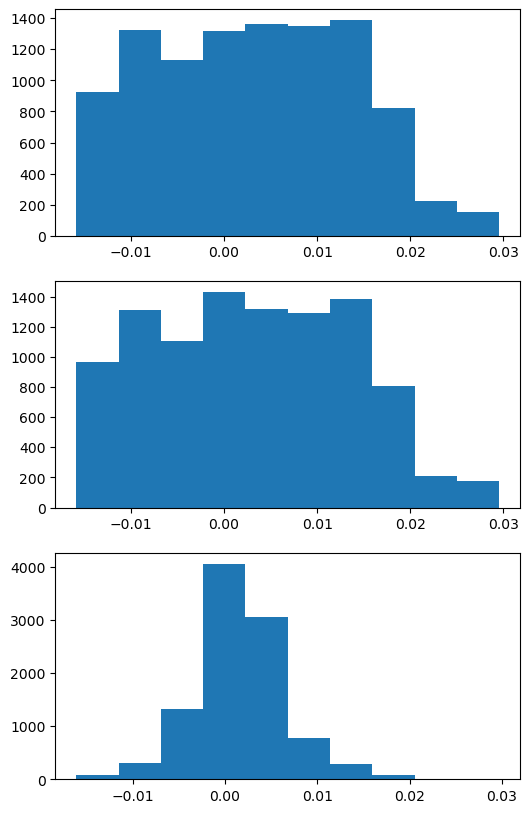

In [146]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))
ax[0].hist(linear_interpolation_from_data(test.iloc[0], 10_000))
ax[1].hist(linear_interpolation_from_data_2(test.iloc[[0]], 10_000, "Log Return").iloc[0])
ax[2].hist(kernel_denstity_estimation_based_sampling(test.iloc[0], 10_000, 0.00025))

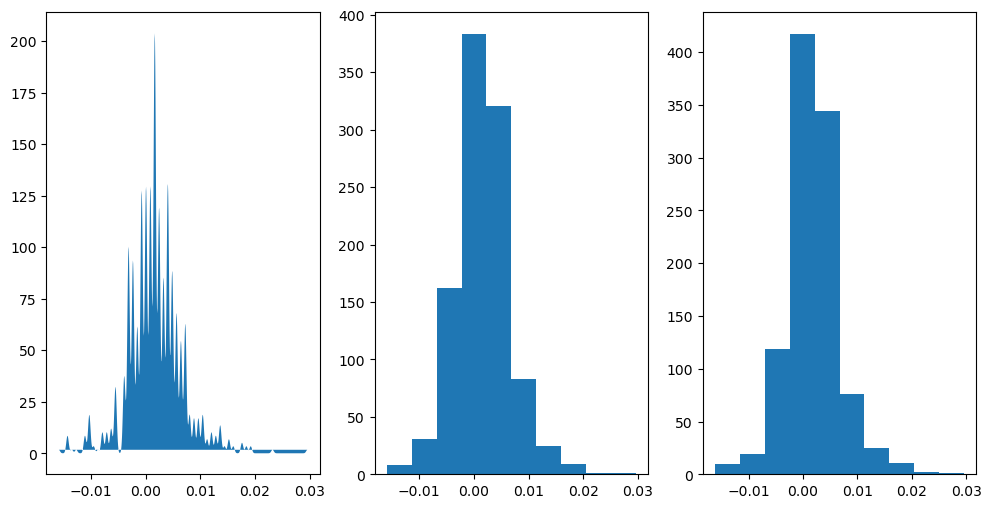

In [147]:
kde_test = KernelDensity(bandwidth=0.00023, kernel="gaussian")
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.sample(n_samples=2**10))

plt.show()

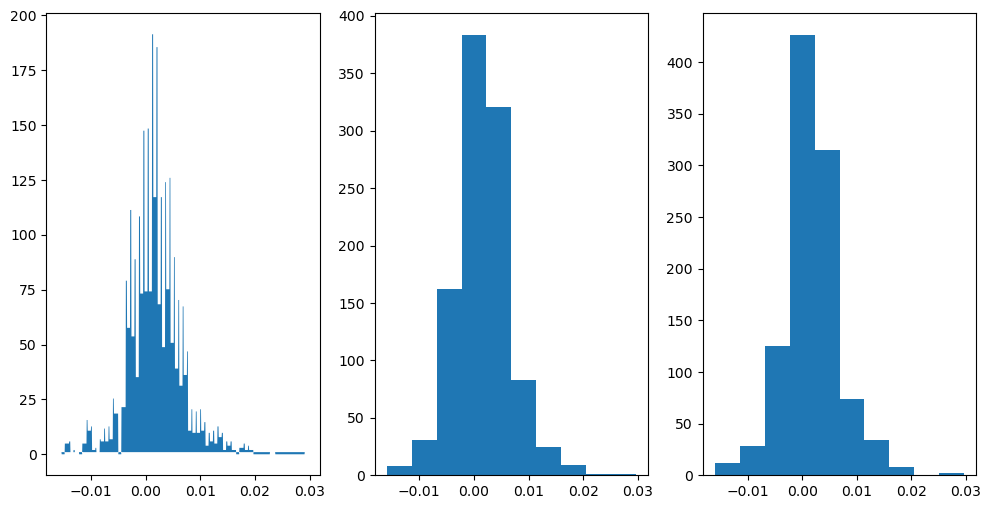

In [148]:
kde_test = KernelDensity(bandwidth=0.0005, kernel="tophat")
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.sample(n_samples=2**10))

plt.show()

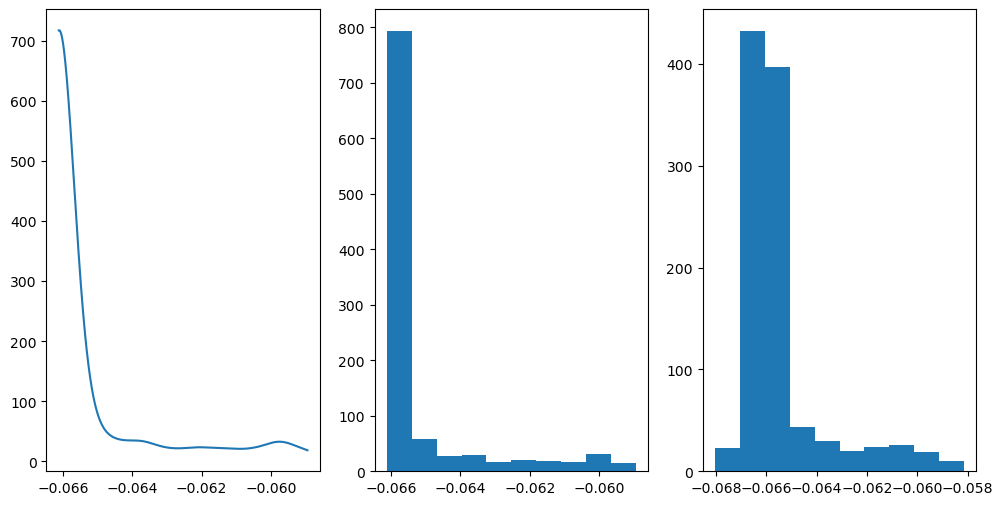

In [120]:
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()
kde_test = gaussian_kde(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)
kde_results = kde_test.pdf(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].plot(X_kde, kde_results)
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.resample(size=2**10).squeeze(0))

plt.show()

In [119]:
kde_test.resample(size=2**10).squeeze(0)

array([-0.06681388, -0.06508559, -0.06593849, ..., -0.06505375,
       -0.06424403, -0.0665128 ])

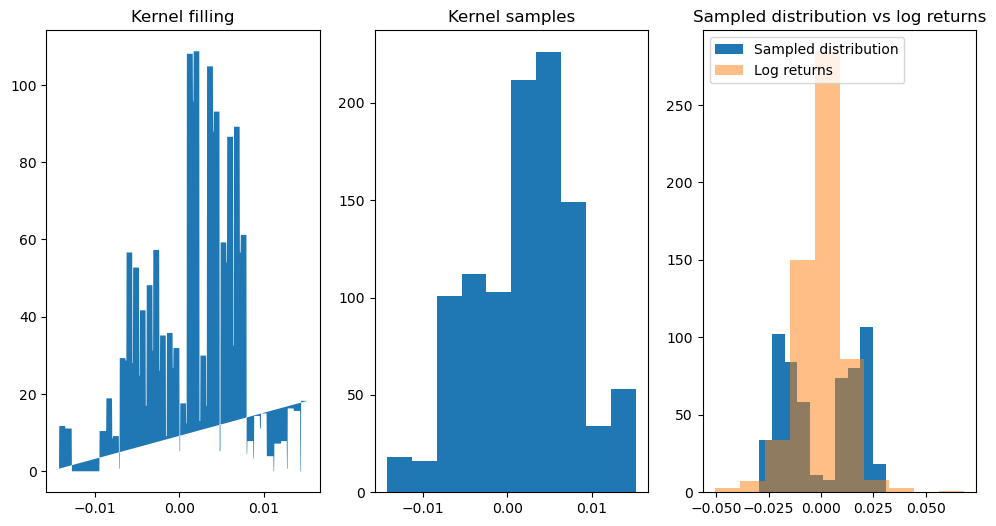

In [80]:
kde_test = KernelDensity(bandwidth=0.00075, kernel="tophat")
test = llmtime_window_predictions["cact"][45]
aligned_log_rets, _ = log_returns_dict["cact"].align(test, join="inner", axis=0)
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[0].set_title("Kernel filling")
ax[1].hist(test.iloc[0])
ax[1].set_title("Kernel samples")
kde_test_samples = kde_test.sample(n_samples=test.shape[0])
kde_samples_to_switch_indices = np.random.choice(range(len(kde_test_samples)), size=test.shape[0] // 2, replace=False)
kde_test_samples[kde_samples_to_switch_indices] -= 2 * np.abs(kde_test_samples[kde_samples_to_switch_indices] - mode(kde_test_samples)[0])
kde_test_samples += -kde_test_samples.mean() + aligned_log_rets.mean()
# kde_test_samples[kde_test_samples > 0] += np.abs(kde_test_samples[kde_test_samples > 0] - kde_test_samples.mean()) * (kde_test_samples[kde_test_samples > 0] + log_returns_dict["cact"].var())
# kde_test_samples[kde_test_samples < 0] -= np.abs(kde_test_samples[kde_test_samples < 0] - kde_test_samples.mean()) * (kde_test_samples[kde_test_samples < 0] - log_returns_dict["cact"].var())
# kde_test_samples += norm(loc=0, scale=log_returns_dict["cact"].var() - kde_test_samples.var()).rvs(size=kde_test_samples.shape)
ax[2].hist(kde_test_samples, label="Sampled distribution")
ax[2].hist(aligned_log_rets, alpha=0.5, label="Log returns")
ax[2].set_title("Sampled distribution vs log returns")
ax[2].legend(loc="upper left")
# test_samples_o1 = pd.read_excel("llm_o1_tests/2024-10-04_cact_o1_w=150.xlsx").set_index("Date")#.iloc[0]
# test_samples_o1 = pd.read_csv("llm_o1_tests/generated_samples_temp_cact_2024-10-07-21-21_w=150.csv", parse_dates=["Date"]).set_index("Date")#.iloc[0]
# ax[2].hist(test_samples_o1.sample(n=1, axis=1), alpha=0.5)


plt.show()

### $Z_2$ test

#### Description

A direct test for ES estimate. Does not assume a correct VaR specification.

#### Test statistic

From the unconditional definition of ES:

$$
\large ES_{\alpha, t} = -\mathop{\mathbb{E}} \left[ \frac{r_t I_t}{\alpha} \right]
$$

authors derive the following statistic:

$$
\large Z_2 = \sum_{t=1}^T \frac{I_t r_t}{T \alpha ES_{\alpha, t}} + 1
$$

with the following hypotheses:

$$
\large \begin{split}
    H_0:\text{ }&P_t^{[\alpha]} = F_t^{[\alpha]}, \forall t \\
    H_1:\text{ }&ES^F_{\alpha, t} \ge ES_{\alpha, t}\text{, for all }t\text{ and }\gt\text{ for some t} \\
    &VaR_t^F(\alpha) \ge VaR_t(\alpha)\text{, for all }t \\
\end{split}
$$

Again, we note that $\large \mathop{\mathbb{E}}_{H_0}[Z_2] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_2] \lt 0$.

As opposed to $Z_1$, $Z_2$ tests both for exceedance frequency and magnitude <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite>.

*We could take advantage of the stable $Z_2$ threshold, computed for significance levek $\eta \in \{5\%, 0.01\%\}$ <cite id="fbz75"><a href="#zotero%7C12595123%2FBTJLF7TJ">(Acerbi &#38; Szekely, 2014)</a></cite>, <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite>.*

In [193]:
def acerbi_szekely_Z2_statistic(window: pd.DataFrame):
    actual_return = window[[col for col in window.columns if "returns" in col]]
    estimated_VaR = window["VaR"].bfill()
    estimated_ES = window["ES"].bfill()

    T = actual_return.shape[0]
    # Indicator function: I_t = 1 if VaR is exceeded computed for each return series
    I = actual_return.lt(estimated_VaR, axis=0).astype(int)

    Z2 = I * actual_return / (T * alpha_ES)
    Z2 = Z2.div(-estimated_ES, axis=0).sum(axis=0) + 1
    
    return Z2

def acerbi_szekely_Z2_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    ).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z2_statistic(llmtime_test_data).iloc[0]
    acerbi_windowed_Z2_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z2_statistic,
        data=llmtime_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z2_results, acerbi_test_statistic

def acerbi_szekely_Z2_test_process_other_methods(estimator: str, asset: str):
    window_VaR_test_data = VaR_predictions[estimator][asset]
    window_ES_test_data = ES_predictions[estimator][asset]
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
    ).merge(
        window_ES_test_data.rename("ES"), how="inner", left_index=True, right_index=True
    ).merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)

    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    acerbi_test_statistic = acerbi_szekely_Z2_statistic(window_acerbi_test_data).iloc[0]
    acerbi_windowed_Z2_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z2_statistic,
        data=window_acerbi_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=(window_volatility_residual_distribution,), asset=asset
    )

    return asset, estimator, acerbi_windowed_Z2_results, acerbi_test_statistic

In [194]:
with tqdm_joblib(tqdm(desc="Z2 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z2_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z2_test_process_llm)(llmtime_test_ticker, llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z2 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z2_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z2_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z2_backtest_results_df = pd.DataFrame(ES_Z2_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z2_backtest_results_df.index.name = ""
ES_Z2_backtest_results_df.columns = ES_Z2_backtest_results_df.columns.get_level_values(0)

ES_Z2_test_statistic_df = pd.DataFrame(ES_Z2_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z2_test_statistic_df.index.name = ""
ES_Z2_test_statistic_df.columns = ES_Z2_test_statistic_df.columns.get_level_values(0)

Z2 ES other methods...: 100%|██████████| 117/117 [00:16<00:00,  7.11it/s]


In [213]:
llmtime_test_ticker, llmtime_test_window = "gdaxi", 30
llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
    llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
    how="inner", left_index=True, right_index=True
).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

acerbi_test_statistic = acerbi_szekely_Z2_statistic(llmtime_test_data).iloc[0]

In [223]:
plt.get_cmap("tab10")(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [224]:
plt.get_cmap("tab10")(3)

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)

In [195]:
ES_Z2_backtest_results_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,0.00000,0.00000,0.00000,0.00000,0.99975,0.00000,0.00000,0.00000,0.00000
llmtime_150,0.99005,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_30,0.00135,0.00000,0.99700,0.00000,0.00000,0.00110,1.00000,0.00000,0.00000
llmtime_60,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_45,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_90,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
garch_lpa,0.11425,0.21050,0.11570,0.52450,0.87330,0.05015,0.37320,0.11790,0.30520
ewma_normal_80,0.01055,0.03115,0.01420,0.35635,0.18240,0.00120,0.00750,0.00000,0.01135
ewma_normal_120,0.03645,0.03445,0.05060,0.09325,0.07190,0.00785,0.08155,0.00000,0.24415


In [196]:
ES_Z2_test_statistic_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,-5.020992,-3.533973,-4.143120,-2.623225,10.287878,-5.862716,-4.191155,-6.644657,-4.595756
llmtime_150,5.312311,-3.055215,-3.481790,-2.497537,-3.351716,-6.931741,-5.138714,-6.744268,-4.350845
llmtime_30,-3.555387,-4.189543,1.564359,-4.624863,-4.083520,-7.906823,16.495477,-5.996595,-9.837815
llmtime_60,-3.140773,-4.233875,-4.191381,-3.337009,-3.392152,-4.632546,-3.916367,-4.602377,-3.352792
llmtime_45,-4.001616,-3.327558,-3.540418,-3.134587,-3.310843,-4.790552,-3.417901,-3.892701,-3.831560
llmtime_90,-5.035707,-3.174887,-3.991304,-2.617753,-3.501776,-4.913141,-4.130647,-5.085124,-3.625646
garch_lpa,0.227618,0.295779,0.161696,0.554144,0.727623,0.023319,0.383712,0.222131,0.340132
ewma_normal_80,0.036664,0.152173,0.075581,0.484948,0.369183,-0.169330,0.013015,-0.439757,0.053655
ewma_normal_120,0.150586,0.143039,0.188255,0.266670,0.226980,-0.018525,0.246769,-0.439757,0.404933


In [159]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z2_df = ES_Z2_backtest_results_df
ES_Z2_statistic_df = ES_Z2_test_statistic_df

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z2_df.index = (ES_Z2_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
ES_Z2_statistic_df.index = (ES_Z2_statistic_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z2_df.columns = ES_Z2_df.columns.str.upper().str.replace('_', '.')
ES_Z2_statistic_df.columns = ES_Z2_statistic_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z2_df.index = ES_Z2_df.index.str.upper().str.replace('_', '.')
ES_Z2_statistic_df.index = ES_Z2_statistic_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z2_df = ES_Z2_df[asset_table_ordering]
ES_Z2_statistic_df = ES_Z2_statistic_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(statistic, p_value):
    # Use a gradient of green and red based on the value
    if p_value > 0.05:
        if p_value > 0.5:
            color = "green!70!white"  # Darker green for higher values
        else:
            color = "green!30!white"  # Lighter green for values near 0.05
    else:
        if p_value < 0.01:
            color = "red!70!white"  # Darker red for lower values
        else:
            color = "red!30!white"  # Lighter red for values near 0.05
    return f"\\cellcolor{{{color}}} {statistic:.3f}"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z2_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z2_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for (idx, pvalues), (_, statistics) in zip(ES_Z2_df.iterrows(), ES_Z2_statistic_df.iterrows()):
    latex_code += f"{idx} & " + " & ".join([format_value(statistic, pval) for statistic, pval in zip(statistics, pvalues)]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z2_df.to_csv(results_directory / "ES_Z2.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z2.tex", "w") as f:
    f.write(latex_code)
    

### $Z_3$ test

#### Description

Expects correct spread of the conditional distribution "ranking" (CDF values) for actual log returns, with an emphasis on the ES tails.

#### Test statistic

Define the empirical ES estimate:

$$
\large \widehat{ES}_{\alpha}^{(N)}(Y) = -\frac{1}{\lfloor N \alpha \rfloor} \sum_{i=1}^{\lfloor N \alpha \rfloor} Y_{i:N}
$$

$U = (P_t(r))_t$ is expected to be i.i.d. $Uniform(0, 1)$ distributed.

To this end, authors propose the following statistic:

$$
\large Z_3 = - \frac{1}{T} \sum_{t=1}^T \frac{\widehat{ES}_{\alpha}^{(T)}(P^{-1}_t(U)}{\mathop{\mathbb{E}}_{V} \left[\widehat{ES}_{\alpha}^{(T)}(P^{-1}_t(V)) \right]} + 1
$$

where $V \sim Uniform (0, 1)$.

$U$ is computed for the conditional distribution of each day using all historical returns and used in the numerator.

The denominator is shown to be equivalent to

$$
\large -\frac{T}{\lfloor T \alpha \rfloor} \int_0^1 I_{1 - p} (T - \lfloor T \alpha \rfloor, \lfloor T \alpha \rfloor) P^{-1}_t(p) dp
$$

where $I_{1-x}(a, b)$ is the incomplete regularized Beta function.

We use Simpson's method for approximating the integral.

Similarly to the other two tests, $\large  \mathop{\mathbb{E}}_{H_0}[Z_3] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_3] \lt 0$.

#### Caveats

*My first gut was that LLM couldn't pass this test because its empirical CDF ususlly outputs very high probabilities, not uniform, as assumed. However, because this test focuses on the tail values, in probably works because of the overall high empirical probabilities.*

Because the test is computationally demanding and the LLM part is not entirely optimized, it will run on less simulations than the rest.
*Keep in mind to set `acerbi_backtesting_test_statistic_n_jobs` accordingly to your system. This test in particular requires a lot of RAM. You can also lower the `batch_size` argument inside the test statistic function for other models, `acerbi_szekely_Z3_statistic_other_methods()`. *

In [186]:
def empirical_inverse_cdf_ES(distribution: pd.Series, quantiles: pd.Series, sample_size: int):
    sorted_distribution = distribution.sort_values(ascending=True)
    distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
    inverse_cdf_samples = sorted_distribution.iloc[distribution_indices].sort_values(ascending=True)
    return -inverse_cdf_samples.iloc[:int(alpha_ES * sample_size)].mean()

def compute_integral_empirical_inverse_trapezium(distribution: pd.Series, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
        sorted_distribution = distribution.sort_values(ascending=True)
        distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
        return sorted_distribution.iloc[distribution_indices].to_numpy()
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * inverse_empirical_cdf(distribution, rectangles)
    return  ((lengths[0] / 2 + lengths[1:-1].sum() + lengths[-1] / 2) * width).sum()

def compute_integral_empirical_inverse_simpson(distribution: pd.Series, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
        sorted_distribution = distribution.sort_values(ascending=True)
        distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
        empirical_distribution_correct = sorted_distribution.iloc[distribution_indices].to_numpy()
        return sorted_distribution.iloc[distribution_indices].to_numpy()
    n_rectangles = n_rectangles - (n_rectangles % 2)
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * inverse_empirical_cdf(distribution, rectangles)
    return  ((lengths[0] + 4 * lengths[1:-1:2].sum() + 2 * lengths[2:-1:2].sum() + lengths[-1]) * width / 3).sum()

def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
    sorted_distribution = distribution.sort_values(ascending=True)
    distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
    return sorted_distribution.iloc[distribution_indices].to_numpy()

# Not used
# Reference when the faster method was developed
def acerbi_szekely_Z3_statistic_llm_slow(window: pd.DataFrame):
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    empirical_distribution_columns = [col for col in window.columns if "distribution" in col]

    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = (
            window[empirical_distribution_columns].lt(window[return_col], axis=0).sum(axis=1) / len(empirical_distribution_columns)
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window[empirical_distribution_columns].apply(
            lambda row: empirical_inverse_cdf_ES(row, window_quantiles, window.shape[0]), 
            axis=1
        )

        # Compute denominators for each day - we use Simpson's rule, although trapezium gives the same result for a large number of evaluations
        betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])        
        denominator = window[empirical_distribution_columns].apply(
            lambda row:  -window.shape[0] / betainc_b * compute_integral_empirical_inverse_simpson(row, a=betainc_a, b=betainc_b, n_rectangles=1_000),
            axis=1
        )
        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)

    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_statistic_llm(window: pd.DataFrame):
    from scipy.special import betainc
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    empirical_distribution_columns = [col for col in window.columns if "distribution" in col]

    # Compute denominator integral - we use Simpson's rule because of better asymptotics, although trapezium gives the same result
    # Speedup is noticeable, however memory cost also increases more than linearly by the number of rectangles
    n_rectangles = 1_000
    # Even number of rectangles for Simpson
    n_rectangles = n_rectangles - (n_rectangles % 2)
    betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])     
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    empirical_distributions = np.sort(window[empirical_distribution_columns].to_numpy(), axis=1)
    empirical_cdf_indices = np.clip((empirical_distributions.shape[1] * rectangles).astype(int), 0, empirical_distributions.shape[1] - 1)
    lengths_daily = betainc(betainc_a, betainc_b, 1 - rectangles)[None, :] * empirical_distributions[:, empirical_cdf_indices]
    denominator = -window.shape[0] / betainc_b * (
        (lengths_daily[:, 0] + 4 * lengths_daily[:, 1:-1:2].sum(axis=1) + 2 * lengths_daily[:, 2:-1:2].sum(axis=1) + lengths_daily[:, -1]) * width / 3
    )
    denominator = pd.Series(denominator, index=window.index)

    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = (
            window[empirical_distribution_columns].lt(window[return_col], axis=0).sum(axis=1) / len(empirical_distribution_columns)
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window[empirical_distribution_columns].apply(
            lambda row: empirical_inverse_cdf_ES(row, window_quantiles, window.shape[0]), 
            axis=1
        )

        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)

    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    )

    acerbi_test_statistic = acerbi_szekely_Z3_statistic_llm(llmtime_test_data).iloc[0]
    acerbi_windowed_Z3_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z3_statistic_llm,
        data=llmtime_test_data, n_simulations=1_000, #acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker, add_all_columns_to_simulation=True
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z3_results, acerbi_test_statistic

In [187]:
def empirical_volatility_ES(variance: float, quantiles: pd.Series, distribution: Callable, rescale_mean: float, rescale_std: float):
    inverse_cdf_samples = np.sort(distribution(loc=0, scale=np.sqrt(variance)).ppf(quantiles))
    inverse_cdf_samples = (inverse_cdf_samples * rescale_std) + rescale_mean
    return -inverse_cdf_samples[:int(alpha_ES * quantiles.shape[0])].mean()

def compute_integral_distribution_trapezium(variance: float, distribution: Callable, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * distribution(loc=0, scale=np.sqrt(variance)).ppf(rectangles)
    return  ((lengths[0] / 2 + lengths[1:-1].sum() + lengths[-1] / 2) * width).sum()

def compute_integral_distribution_simpson(variance: float, distribution: Callable, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    n_rectangles = n_rectangles - (n_rectangles % 2)
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * distribution(loc=0, scale=np.sqrt(variance)).ppf(rectangles)
    return  ((lengths[0] + 4 * lengths[1:-1:2].sum() + 2 * lengths[2:-1:2].sum() + lengths[-1]) * width / 3).sum()

# Not used
# Reference when the faster method was developed
def acerbi_szekely_Z3_statistic_other_methods_slow(window: pd.DataFrame, distribution: Callable[[float, float], Any]):
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = window.apply(
            lambda row: distribution(loc=0, scale=np.sqrt(row["volatility"])).cdf((row[return_col] - row["rescale_mean"]) / row["rescale_std"]),
            axis=1
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window.apply(
            lambda row: empirical_volatility_ES(row["volatility"], window_quantiles, distribution, row["rescale_mean"], row["rescale_std"]),
            axis=1
        )
    
        # Compute denominators for each day - we use Simpson's rule, although trapezium gives the same result for a large number of evaluations
        betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])        
        denominator = window["volatility"].map(
            lambda row:  -window.shape[0] / betainc_b * compute_integral_distribution_simpson(row, distribution=distribution, a=betainc_a, b=betainc_b, n_rectangles=1_000)
        )
    
        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)
    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_statistic_other_methods(window: pd.DataFrame, distribution: Callable[[float, float], Any]):
    from scipy.special import betainc
    return_columns = [col for col in window.columns if "return" in col]

    # Compute all quantiles at once for the standardized distribution and then multiply by the daily standard deviation
    window_std_deviations = np.sqrt(window["volatility"]).to_numpy()
    standardized_returns = window[return_columns].subtract(window["rescale_mean"], axis=0).div(window["rescale_std"], axis=0).to_numpy()
    window_quantiles = distribution(loc=0, scale=1).cdf(standardized_returns / window_std_deviations[:, None])

    # Compute and invert quantiles at once for the standardized distribution
    # Uses the location-mean nature of our distributions
    # Copy quantiles to form a 3D array of size (day, return_col, quantiles) for faster processing
    # Batched processing (1 item in batch = 1 return col) because the full array does not fit into memory
    # Decrease if memory issues occur
    batch_size = 3
    empirical_ES = np.zeros_like(window_quantiles, dtype="float64")
    rescale_std = window["rescale_std"].to_numpy()
    rescale_mean = window["rescale_mean"].to_numpy()
    for batch_index in range(0, len(return_columns), batch_size):
        window_quantiles_slice = distribution(loc=0, scale=1).ppf(window_quantiles[:, batch_index:batch_index + batch_size, None])
        window_quantiles_slice = np.tile(window_quantiles_slice, (1, 1, window.shape[0]))
        window_inverse_quantiles = window_quantiles_slice * window_std_deviations[None, None, :]
        window_inverse_quantiles = np.sort((window_inverse_quantiles * rescale_std[None, None, :]) + rescale_mean[None, None, :], axis=0)
    
        # Compute empirical ES
        empirical_ES[:, batch_index:batch_index + batch_size] = -window_inverse_quantiles[:int(alpha_ES * window.shape[0]), :, :].mean(axis=0).T
    empirical_ES = pd.DataFrame(empirical_ES, index=window.index, columns=return_columns)

    # Compute denominator integral - we use Simpson's rule because of better asymptotics, although trapezium gives the same result
    # Speedup is noticeable, however memory cost also increases more than linearly by the number of rectangles
    n_rectangles = 1_000
    # Even number of rectangles for Simpson
    n_rectangles = n_rectangles - (n_rectangles % 2)
    betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])     
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(betainc_a, betainc_b, 1 - rectangles) * distribution(loc=0, scale=1).ppf(rectangles)
    lengths_daily = np.tile(lengths[:, None], (1, window.shape[0])).reshape(-1, window.shape[0]).T
    lengths_daily_test = lengths_daily.copy()
    lengths_daily = lengths_daily * window_std_deviations[:, None]
    denominator = -window.shape[0] / betainc_b * (
        (lengths_daily[:, 0] + 4 * lengths_daily[:, 1:-1:2].sum(axis=1) + 2 * lengths_daily[:, 2:-1:2].sum(axis=1) + lengths_daily[:, -1]) * width / 3
    )
    denominator = pd.Series(denominator, index=window.index)
    
    # Compute the test statistic
    acerbi_Z3_results = -1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum(axis=0) + 1
    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_test_process_other_methods(estimator: str, asset: str):
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)
    else:
        window_acerbi_test_data["rescale_mean"] = 0
        window_acerbi_test_data["rescale_std"] = 1

    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    if window_volatility_residual_distribution == "normal":
        volatility_distribution_func = lambda loc, scale: norm(loc=loc, scale=scale)
    else:
        volatility_distribution_func = lambda loc, scale: t(loc=loc, scale=scale, df=t_nu)
        
    acerbi_test_statistic = acerbi_szekely_Z3_statistic_other_methods(window_acerbi_test_data, volatility_distribution_func).iloc[0]
    acerbi_windowed_Z3_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z3_statistic_other_methods,
        data=window_acerbi_test_data, n_simulations=1_000,
        simulator_params=(window_volatility_residual_distribution,), statistic_calculator_params=(volatility_distribution_func,), 
        add_all_columns_to_simulation=True, asset=asset
    )

    return asset, estimator, acerbi_windowed_Z3_results, acerbi_test_statistic

In [192]:
with tqdm_joblib(tqdm(desc="Z3 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z3_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z3_test_process_llm)(llmtime_test_ticker,
                                                    llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z3 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z3_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z3_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z3_backtest_results_df = pd.DataFrame(ES_Z3_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z3_backtest_results_df.index.name = ""
ES_Z3_backtest_results_df.columns = ES_Z3_backtest_results_df.columns.get_level_values(0)

ES_Z3_test_statistic_df = pd.DataFrame(ES_Z3_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z3_test_statistic_df.index.name = ""
ES_Z3_test_statistic_df.columns = ES_Z3_test_statistic_df.columns.get_level_values(0)

Z3 ES LLM...: 100%|██████████| 54/54 [00:05<00:00,  9.76it/s]


KeyboardInterrupt: 

In [189]:
ES_Z3_backtest_results_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_150,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_60,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_45,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_90,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
garch_lpa,0.999,0.942,0.997,0.978,0.982,0.998,1.000,0.895,0.998
ewma_normal_80,0.011,0.003,0.000,0.194,0.123,0.000,0.001,0.000,0.000
ewma_normal_120,0.038,0.000,0.006,0.100,0.048,0.000,0.001,0.000,0.003


In [190]:
ES_Z3_test_statistic_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,-0.498444,-0.454604,-0.630999,-0.606220,-0.353391,-0.745168,-0.577992,-0.997992,-0.595781
llmtime_150,-0.345273,-0.483940,-0.660852,-0.442740,-0.441485,-0.671794,-0.588177,-0.954787,-0.590894
llmtime_30,-0.311859,-0.307451,-0.420878,-0.383898,-0.326080,-0.476973,-0.476296,-0.613227,-0.572292
llmtime_60,-0.473151,-0.591631,-0.573128,-0.363036,-0.442152,-0.647948,-0.550527,-0.835623,-0.571907
llmtime_45,-0.525763,-0.452449,-0.528113,-0.342517,-1.443829,-0.566589,-0.497773,-0.738351,-0.527553
llmtime_90,1.432001,-0.500039,-0.601449,-0.408870,-0.424870,-0.622857,-0.564093,-0.928184,-0.588702
garch_lpa,0.989126,0.981722,0.987949,0.987923,0.994744,0.991400,0.990716,0.958729,0.988734
ewma_normal_80,-0.214115,-0.261985,-0.266097,-0.120136,-0.141036,-0.445253,-0.340695,-0.509100,-0.364019
ewma_normal_120,-0.190142,-0.302709,-0.235733,-0.146140,-0.173382,-0.384268,-0.254596,-0.509100,-0.247113


In [191]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z3_df = ES_Z3_backtest_results_df
ES_Z3_statistic_df = ES_Z3_test_statistic_df

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z3_df.index = (ES_Z3_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
ES_Z3_statistic_df.index = (ES_Z3_statistic_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z3_df.columns = ES_Z3_df.columns.str.upper().str.replace('_', '.')
ES_Z3_statistic_df.columns = ES_Z3_statistic_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z3_df.index = ES_Z3_df.index.str.upper().str.replace('_', '.')
ES_Z3_statistic_df.index = ES_Z3_statistic_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z3_df = ES_Z3_df[asset_table_ordering]
ES_Z3_statistic_df = ES_Z3_statistic_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(statistic, p_value):
    # Use a gradient of green and red based on the value
    if p_value > 0.05:
        if p_value > 0.5:
            color = "green!70!white"  # Darker green for higher values
        else:
            color = "green!30!white"  # Lighter green for values near 0.05
    else:
        if p_value < 0.01:
            color = "red!70!white"  # Darker red for lower values
        else:
            color = "red!30!white"  # Lighter red for values near 0.05
    return f"\\cellcolor{{{color}}} {statistic:.3f}"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z3_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z3_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for (idx, pvalues), (_, statistics) in zip(ES_Z3_df.iterrows(), ES_Z3_statistic_df.iterrows()):
    latex_code += f"{idx} & " + " & ".join([format_value(statistic, pval) for statistic, pval in zip(statistics, pvalues)]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z3_df.to_csv(results_directory / "ES_Z3.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z3.tex", "w") as f:
    f.write(latex_code)
    

In [197]:
experiments_simulations_directory =  Path("llm_window_tests")
extra_llmtime_window_predictions = {
    asset: read_llmtime_simulations(asset, experiments_simulations_directory) 
    for asset in tqdm(read_llmtime_assets(experiments_simulations_directory), desc="Reading experiments...")
}

Reading experiments...: 100%|██████████| 4/4 [01:06<00:00, 16.62s/it]


In [ ]:
llmtime

In [57]:
llm_failure_rates = pd.DataFrame.from_dict([backtest_failure_rates[estimator] for estimator in backtest_failure_rates.keys() if "llmtime" in estimator])["CRIX"]
llm_failure_rates.index = llm_failure_rates.index.map(lambda text: int(text.split("_")[1]))
llm_failure_rates = llm_failure_rates.sort_index()

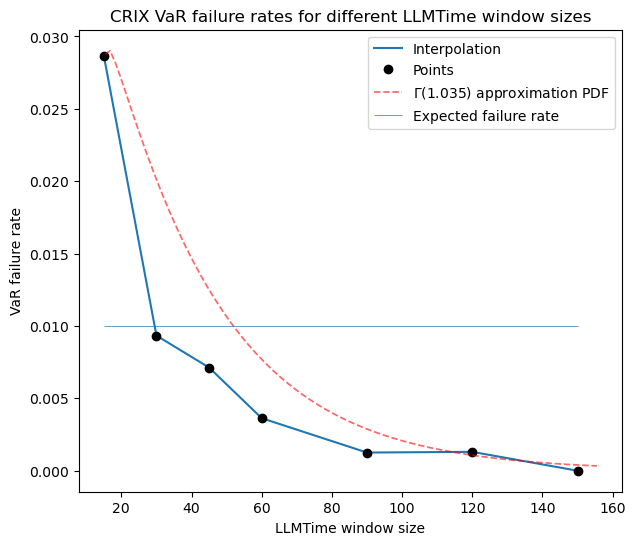

In [125]:
plt.figure(figsize=(7, 6))

llm_failure_rates.plot.line(label="Interpolation")
llm_points = llm_failure_rates.to_dict()
plt.plot(list(llm_points.keys()), list(llm_points.values()), 'ko', label="Points")
a = (1.035, 15, 30)
x = np.linspace(gamma.ppf(0.01, *a), gamma.ppf(0.99, *a), 100)
plt.plot(x, gamma.pdf(x, *a), 'r--', lw=1.25, alpha=0.6, label=r'$\Gamma(1.035)$ approximation PDF')
plt.hlines(0.01, xmin=15, xmax=150, lw=0.5, linestyle="-", label="Expected failure rate")

plt.title("CRIX VaR failure rates for different LLMTime window sizes")
plt.xlabel("LLMTime window size")
plt.ylabel("VaR failure rate")
plt.legend()

plt.savefig("workshop/failure_rate_plot.png", bbox_inches="tight")

# Bibliography

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|12595123/BTJLF7TJ"></i>Acerbi, C., &#38; Szekely, B. (2014). Back-testing expected shortfall. <i>Risk</i>, <i>27</i>(11), 76–81.</div>
  <div class="csl-entry"><i id="zotero|12595123/A9UGX7MM"></i>Acerbi, C., &#38; Székely, B. (2023). Backtestability and the ridge backtest. <i>Frontiers of Mathematical Finance</i>, <i>2</i>(4), 497–521. <a href="https://doi.org/10.3934/fmf.2023019">https://doi.org/10.3934/fmf.2023019</a></div>
  <div class="csl-entry"><i id="zotero|12595123/T2GHH5LV"></i>Alexander, C., &#38; Dakos, M. (2023). Assessing the accuracy of exponentially weighted moving average models for Value-at-Risk and Expected Shortfall of crypto portfolios. <i>Quantitative Finance</i>, <i>23</i>(3), 393–427. <a href="https://doi.org/10.1080/14697688.2022.2159505">https://doi.org/10.1080/14697688.2022.2159505</a></div>
  <div class="csl-entry"><i id="zotero|12595123/SYW4CGYB"></i>Bayer, S., &#38; Dimitriadis, T. (2022). Regression-Based Expected Shortfall Backtesting. <i>Journal of Financial Econometrics</i>, <i>20</i>(3), 437–471. <a href="https://doi.org/10.1093/jjfinec/nbaa013">https://doi.org/10.1093/jjfinec/nbaa013</a></div>
  <div class="csl-entry"><i id="zotero|12595123/66IRPRTK"></i>Benito Muela, S., López-Martin, C., &#38; Arguedas-Sanz, R. (2023). A comparison of market risk measures from a twofold perspective: accurate and loss function. <i>ACRN Journal of Finance and Risk Perspectives</i>, <i>11</i>(1), 79–104. <a href="https://doi.org/10.35944/jofrp.2022.11.1.005">https://doi.org/10.35944/jofrp.2022.11.1.005</a></div>
  <div class="csl-entry"><i id="zotero|12595123/SEBZ3T4X"></i>Clift, S., Costanzino, N., &#38; Curran, M. (2016). <i>Empirical Performance of Backtesting Methods for Expected Shortfall</i> (SSRN Scholarly Paper No. 2618345). Social Science Research Network. <a href="https://doi.org/10.2139/ssrn.2618345">https://doi.org/10.2139/ssrn.2618345</a></div>
  <div class="csl-entry"><i id="zotero|12595123/YJRN36EJ"></i>Costanzino, N., &#38; Curran, M. (2015). <i>Backtesting General Spectral Risk Measures with Application to Expected Shortfall</i> (SSRN Scholarly Paper No. 2514403). Social Science Research Network. <a href="https://doi.org/10.2139/ssrn.2514403">https://doi.org/10.2139/ssrn.2514403</a></div>
  <div class="csl-entry"><i id="zotero|12595123/FX5YUCYG"></i>Costanzino, N., &#38; Curran, M. (2018). A Simple Traffic Light Approach to Backtesting Expected Shortfall. <i>Risks</i>, <i>6</i>(1), 2. <a href="https://doi.org/10.3390/risks6010002">https://doi.org/10.3390/risks6010002</a></div>
  <div class="csl-entry"><i id="zotero|12595123/EKNNRH67"></i>Efron, B., &#38; Tibshirani, R. J. (1994). <i>An Introduction to the Bootstrap</i> (0 ed.). Chapman and Hall/CRC. <a href="https://doi.org/10.1201/9780429246593">https://doi.org/10.1201/9780429246593</a></div>
  <div class="csl-entry"><i id="zotero|12595123/5ZQTSP9P"></i>Karim, A., Alessandra, L., &#38; Paolo, P. (2023). GARCH density and functional forecasts. <i>Journal of Econometrics</i>, <i>235</i>(2), 470–483. <a href="https://doi.org/10.1016/j.jeconom.2022.04.010">https://doi.org/10.1016/j.jeconom.2022.04.010</a></div>
  <div class="csl-entry"><i id="zotero|12595123/UDNZXFSP"></i>Lazar, E., &#38; Zhang, N. (2019). Model risk of expected shortfall. <i>Journal of Banking &#38; Finance</i>, <i>105</i>, 74–93. <a href="https://doi.org/10.1016/j.jbankfin.2019.05.017">https://doi.org/10.1016/j.jbankfin.2019.05.017</a></div>
  <div class="csl-entry"><i id="zotero|12595123/7G6HYGQV"></i>McNeil, A. J., &#38; Frey, R. (2000). Estimation of tail-related risk measures for heteroscedastic financial time series: an extreme value approach. <i>Journal of Empirical Finance</i>, <i>7</i>(3–4), 271–300. <a href="https://doi.org/10.1016/S0927-5398(00)00012-8">https://doi.org/10.1016/S0927-5398(00)00012-8</a></div>
  <div class="csl-entry"><i id="zotero|12595123/2IS5JMHB"></i>McNeil, A. J., Frey, R., &#38; Embrechts, P. (2015). <i>Quantitative Risk Management: Concepts, Techniques and Tools - Revised Edition</i>. Princeton University Press.</div>
</div>
<!-- BIBLIOGRAPHY END -->